In [1]:
#set up packages
import sklearn
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from yellowbrick.classifier import ROCAUC
from yellowbrick.regressor import ResidualsPlot
from scipy import stats
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import pandasql
import statsmodels.api as sm
import statsmodels.formula.api as smf
import xgboost

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

import os
import requests
import datetime
from datetime import date, timedelta


C:\Users\rguse\Anaconda3\envs\conda_env\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#POPULATE API KEY FROM ENVIRONMENT VARIABLE (whoever is reading and wants to run this code should get their own API KEY at:
#https://research.stlouisfed.org/docs/api/api_key.html and set it to the environment variable FED_API_KEY)
fed_api_key = os.environ.get("FED_API_KEY")

In [3]:
#GET US RECESSIONS, UNEMPLOYMENT, and YIELD SPREAD (10yr - 3mo treasury rate) from the Fed API

USREC_URL = 'https://api.stlouisfed.org/fred/series/observations?series_id=USREC&api_key=%s&file_type=json'%fed_api_key
USREC = requests.get(USREC_URL)

UNRATE_URL = 'https://api.stlouisfed.org/fred/series/observations?series_id=UNRATE&api_key=%s&file_type=json'%fed_api_key
UNRATE = requests.get(UNRATE_URL)

YIELD_SPREAD_URL = 'https://api.stlouisfed.org/fred/series/observations?series_id=T10Y3M&api_key=%s&file_type=json'%fed_api_key
YIELD_SPREAD = requests.get(YIELD_SPREAD_URL)

In [4]:
#PARSE RESPONSES INTO JSON 

USREC_JSON = (USREC.json())
UNRATE_JSON = (UNRATE.json())
YIELD_SPREAD_JSON = (YIELD_SPREAD.json())


In [5]:
#PARSE JSONS INTO PANDAS DATAFRAMES

USREC_DF = pd.DataFrame(USREC_JSON['observations'])
UNRATE_DF = pd.DataFrame(UNRATE_JSON['observations'])
YIELD_SPREAD_DF = pd.DataFrame(YIELD_SPREAD_JSON['observations'])


In [6]:
#only need date and value columns
USREC_DF_FINAL = USREC_DF[['date','value']]
UNRATE_DF_FINAL = UNRATE_DF[['date','value']]
YIELD_SPREAD_DF_FINAL = YIELD_SPREAD_DF[['date','value']]


In [7]:
#rename value columns to prevent confusion when generating consolidated dataframe
USREC_DF_FINAL['recession'] = USREC_DF_FINAL['value']
USREC_DF_FINAL = USREC_DF_FINAL.drop(columns=['value'])

UNRATE_DF_FINAL['unemployment'] = UNRATE_DF_FINAL['value']
UNRATE_DF_FINAL = UNRATE_DF_FINAL.drop(columns=['value'])

YIELD_SPREAD_DF_FINAL['spread'] = YIELD_SPREAD_DF_FINAL['value']
YIELD_SPREAD_DF_FINAL = YIELD_SPREAD_DF_FINAL.drop(columns=['value'])

C:\Users\rguse\Anaconda3\envs\conda_env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\rguse\Anaconda3\envs\conda_env\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\rguse\Anaconda3\envs\conda_env\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [8]:
#yield spread data is daily while unemployment and recession data is monthly, therefore, 
#I create a new yield_spread dataframe where each row represents 1 month and has the mean spread for that month as the value.
#I also clean up missing yield spread entries which have a value of '.'

# Get names of indexes for which column spread has a value of '.'
missing_yield_index = YIELD_SPREAD_DF_FINAL[YIELD_SPREAD_DF_FINAL['spread'] == '.' ].index
 
# Delete these row indexes from dataFrame
YIELD_SPREAD_DF_FINAL.drop(missing_yield_index, inplace=True)

#set the date column to be datetime
YIELD_SPREAD_DF_FINAL["date"] = pd.to_datetime(YIELD_SPREAD_DF_FINAL['date'])
#make a datetime index for running the monthly mean function
YIELD_SPREAD_DF_FINAL.index = YIELD_SPREAD_DF_FINAL['date']
#set the spread column to float
YIELD_SPREAD_DF_FINAL["spread"] = YIELD_SPREAD_DF_FINAL.spread.astype(float)
#create monthly dataframe
YIELD_SPREAD_DF_MONTHLY = YIELD_SPREAD_DF_FINAL.resample('M').mean()

#recreate the date column from the index
YIELD_SPREAD_DF_MONTHLY['date'] = YIELD_SPREAD_DF_MONTHLY.index.values
#reset the index to not longer be based on datetime
YIELD_SPREAD_DF_MONTHLY= YIELD_SPREAD_DF_MONTHLY.reset_index(drop=True)

#the mean function sets the date column to be the end of the month. for our final dataframe join to work we need it to be
#the beginning of the month instead (to match the other 2 dataframe). 
#I create the following function to apply to the date column:

def get_first_day(dt, d_years=0, d_months=0):
    # d_years, d_months are "deltas" to apply to dt
    y, m = dt.year + d_years, dt.month + d_months
    a, m = divmod(m-1, 12)
    return datetime.date(y+a, m+1, 1)

YIELD_SPREAD_DF_MONTHLY['date'] = YIELD_SPREAD_DF_MONTHLY['date'].apply(get_first_day)


In [9]:
#INNER JOIN DFS ON DATE FOR SINGLE UNIFIED DATAFRAME
DF_JOIN_1 = pd.merge(USREC_DF_FINAL,UNRATE_DF_FINAL, on='date')
DF_JOIN_1["date"] = pd.to_datetime(DF_JOIN_1['date'])
YIELD_SPREAD_DF_MONTHLY["date"] = pd.to_datetime(YIELD_SPREAD_DF_MONTHLY['date'])
DF_RAW = pd.merge(DF_JOIN_1,YIELD_SPREAD_DF_MONTHLY, on = 'date')


In [10]:
#save raw dataframe
DF_RAW.to_csv(r'datasets\recession\raw_df.csv', index = False)

In [11]:
DF_RAW.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 457 entries, 0 to 456
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          457 non-null    datetime64[ns]
 1   recession     457 non-null    object        
 2   unemployment  457 non-null    object        
 3   spread        457 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 17.9+ KB


In [12]:
#convert recession to int
#convert unemployment rate to float

DF_RAW["recession"] = DF_RAW.recession.astype(int)
DF_RAW["unemployment"] = DF_RAW.unemployment.astype(float)


In [13]:
DF_RAW.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 457 entries, 0 to 456
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          457 non-null    datetime64[ns]
 1   recession     457 non-null    int32         
 2   unemployment  457 non-null    float64       
 3   spread        457 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int32(1)
memory usage: 16.1 KB


In [14]:
#create depended/outcome variables, for recession within 1, 2, 3 and 4 years

recessions = DF_RAW[DF_RAW['recession'] == 1]
recession_dates = recessions[["date"]]
recession_dates['one_year_before_rec'] = (recession_dates["date"] - pd.DateOffset(years=1))
recession_dates['two_year_before_rec'] = (recession_dates["date"] - pd.DateOffset(years=2))
recession_dates['three_year_before_rec'] = (recession_dates["date"] - pd.DateOffset(years=3))
recession_dates['four_year_before_rec'] = (recession_dates["date"] - pd.DateOffset(years=4))

one_year_rec = pandasql.sqldf("select date, 1 from DF_RAW t where exists (select 1 from recession_dates t2 where t.date < t2.date and t.date >= t2.one_year_before_rec);", globals())
two_year_rec = pandasql.sqldf("select date, 1 from DF_RAW t where exists (select 1 from recession_dates t2 where t.date < t2.date and t.date >= t2.two_year_before_rec);", globals())
three_year_rec = pandasql.sqldf("select date, 1 from DF_RAW t where exists (select 1 from recession_dates t2 where t.date < t2.date and t.date >= t2.three_year_before_rec);", globals())
four_year_rec = pandasql.sqldf("select date, 1 from DF_RAW t where exists (select 1 from recession_dates t2 where t.date < t2.date and t.date >= t2.four_year_before_rec);", globals())

one_year_rec = one_year_rec.rename(columns={"1":"recession_1yr"})
two_year_rec = two_year_rec.rename(columns={"1":"recession_2yr"})
three_year_rec = three_year_rec.rename(columns={"1":"recession_3yr"})
four_year_rec = four_year_rec.rename(columns={"1":"recession_4yr"})

one_year_rec["date"] = pd.to_datetime(one_year_rec['date'])
two_year_rec["date"] = pd.to_datetime(two_year_rec['date'])
three_year_rec["date"] = pd.to_datetime(three_year_rec['date'])
four_year_rec["date"] = pd.to_datetime(four_year_rec['date'])

#left join to the main dataframe
DF_PROCESSED = pd.merge(DF_RAW,one_year_rec, on='date',how='left')
DF_PROCESSED = pd.merge(DF_PROCESSED,two_year_rec, on='date',how='left')
DF_PROCESSED = pd.merge(DF_PROCESSED,three_year_rec, on='date',how='left')
DF_PROCESSED = pd.merge(DF_PROCESSED,four_year_rec, on='date',how='left')

#fill the missing values with 0 (which means there was no recession)
DF_PROCESSED["recession_1yr"].fillna(0, inplace = True) 
DF_PROCESSED["recession_2yr"].fillna(0, inplace = True) 
DF_PROCESSED["recession_3yr"].fillna(0, inplace = True) 
DF_PROCESSED["recession_4yr"].fillna(0, inplace = True) 

#change type of newly created dependent variables to int
DF_PROCESSED["recession_1yr"] = DF_PROCESSED.recession_1yr.astype(int)
DF_PROCESSED["recession_2yr"] = DF_PROCESSED.recession_2yr.astype(int)
DF_PROCESSED["recession_3yr"] = DF_PROCESSED.recession_3yr.astype(int)
DF_PROCESSED["recession_4yr"] = DF_PROCESSED.recession_4yr.astype(int)

DF_PROCESSED

C:\Users\rguse\Anaconda3\envs\conda_env\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\rguse\Anaconda3\envs\conda_env\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,date,recession,unemployment,spread,recession_1yr,recession_2yr,recession_3yr,recession_4yr
0,1982-01-01,1,8.6,1.676000,1,1,1,1
1,1982-02-01,1,8.9,0.146111,1,1,1,1
2,1982-03-01,1,9.0,0.546522,1,1,1,1
3,1982-04-01,1,9.3,0.527143,1,1,1,1
4,1982-05-01,1,9.4,0.908500,1,1,1,1
...,...,...,...,...,...,...,...,...
452,2019-09-01,0,3.5,-0.235000,0,0,0,0
453,2019-10-01,0,3.6,0.028182,0,0,0,0
454,2019-11-01,0,3.5,0.240000,0,0,0,0
455,2019-12-01,0,3.5,0.297619,0,0,0,0


In [15]:
#save processed dataframe
DF_PROCESSED.to_csv(r'datasets\recession\processed_df.csv', index = False)



In [16]:
DF_PROCESSED

,date,recession,unemployment,spread,recession_1yr,recession_2yr,recession_3yr,recession_4yr
0,1982-01-01,1,8.6,1.676000,1,1,1,1
1,1982-02-01,1,8.9,0.146111,1,1,1,1
2,1982-03-01,1,9.0,0.546522,1,1,1,1
3,1982-04-01,1,9.3,0.527143,1,1,1,1
4,1982-05-01,1,9.4,0.908500,1,1,1,1
...,...,...,...,...,...,...,...,...
452,2019-09-01,0,3.5,-0.235000,0,0,0,0
453,2019-10-01,0,3.6,0.028182,0,0,0,0
454,2019-11-01,0,3.5,0.240000,0,0,0,0
455,2019-12-01,0,3.5,0.297619,0,0,0,0


In [17]:
#summary stats
DF_PROCESSED.describe()

,recession,unemployment,spread,recession_1yr,recession_2yr,recession_3yr,recession_4yr
count,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000
mean,0.098468,6.130197,1.772953,0.168490,0.247265,0.326039,0.404814
std,0.298273,1.704563,1.112278,0.374711,0.431895,0.469276,0.491394
min,0.000000,3.500000,-0.696500,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.900000,0.908500,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.700000,1.878000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,7.200000,2.647895,0.000000,0.000000,1.000000,1.000000
max,1.000000,10.800000,4.146190,1.000000,1.000000,1.000000,1.000000


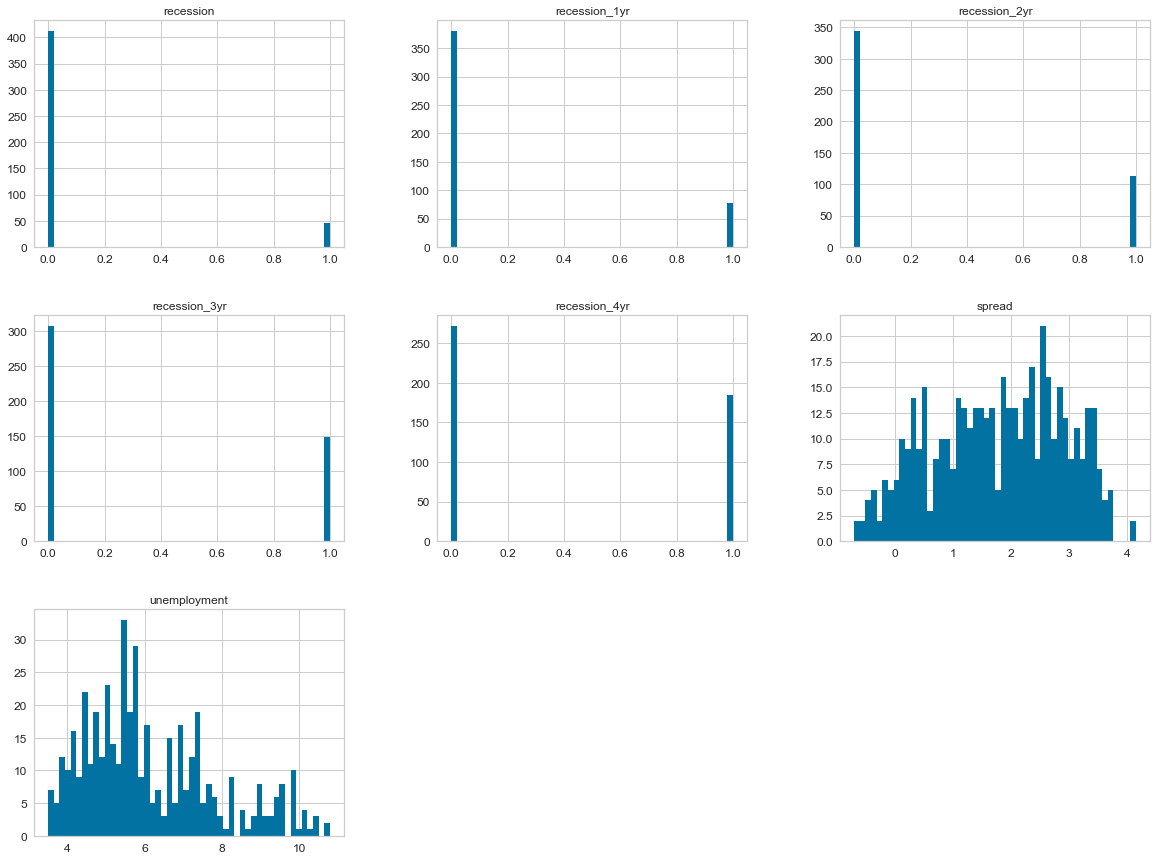

In [18]:
#Histrograms
DF_PROCESSED.hist(bins=50, figsize=(20,15))
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018782E27B88>,
      dtype=object)

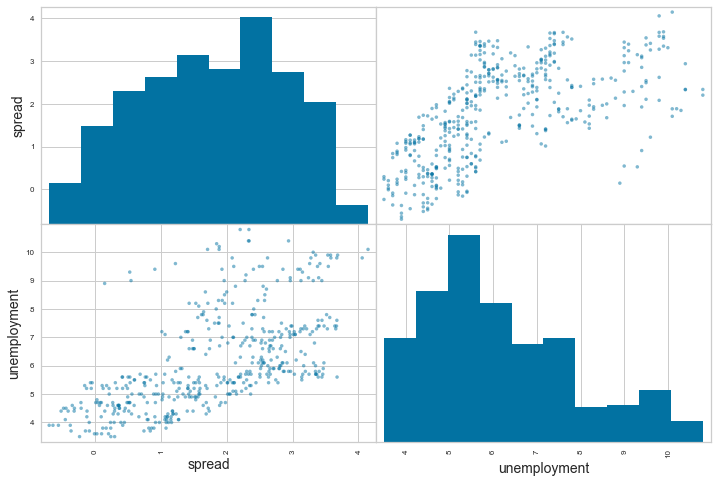

In [19]:
#correlation plot
attributes = ["spread","unemployment"]
scatter_matrix(DF_PROCESSED[attributes],figsize=(12,8))

Spread and unemployment seem to be very correlated, therefore we will want to add some regularization or perform PCA on the variables to get rid of multicollinearity

In [20]:
#set up the matrices for regressions
#model_df_1yr_y = Combined_DF["recession_1yr"]
#model_df_1yr_x = Combined_DF[["unemp_bin"]]

#model_df_2yr_y = Combined_DF["recession_2yr"]
#model_df_2yr_x = Combined_DF[["unemp_bin"]]

y_3yr = DF_PROCESSED["recession_3yr"]
X_3yr = DF_PROCESSED[["unemployment","spread"]]

#model_df_4yr_y = DF_PROCESSED["recession_4yr"]
#model_df_4yr_x = DF_PROCESSED[["unemp_bin"]]


In [21]:
#train, test split
X_train, X_test, y_train, y_test = train_test_split(X_3yr, y_3yr, test_size=0.2, random_state=42)

In [22]:
#Baseline Model

baseline_clf = DummyClassifier(strategy="most_frequent")
baseline_clf.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

In [23]:
y_baseline_pred = cross_val_predict(baseline_clf,X_train,y_train,cv=5 )

In [24]:
confusion_matrix(y_train,y_baseline_pred)

array([[249,   0],
       [116,   0]], dtype=int64)

In [25]:
baseline_clf.score(X_train, y_train) 

0.6821917808219178

In [26]:
#logistic model fit
logit_mod = sm.Logit(y_train,X_train)
logit_res = logit_mod.fit()
print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.497971
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          recession_3yr   No. Observations:                  365
Model:                          Logit   Df Residuals:                      363
Method:                           MLE   Df Model:                            1
Date:                Wed, 04 Mar 2020   Pseudo R-squ.:                  0.2035
Time:                        12:43:26   Log-Likelihood:                -181.76
converged:                       True   LL-Null:                       -228.20
Covariance Type:            nonrobust   LLR p-value:                 5.551e-22
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
unemployment     0.1929      0.046      4.177      0.000       0.102       0.283
spread          -1.2605

In [27]:
#fit logistic ridge regressions

#LogReg_1yr = LogisticRegression()
#LogReg_1yr.fit(model_df_1yr_x,model_df_1yr_y)

#LogReg_2yr = LogisticRegression()
#LogReg_2yr.fit(model_df_2yr_x,model_df_2yr_y)

LogReg_3yr = LogisticRegression(penalty='l2')
LogReg_3yr.fit(X_train,y_train)

#LogReg_4yr = LogisticRegression()
#LogReg_4yr.fit(model_df_4yr_x,model_df_4yr_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
y_train_pred = cross_val_predict(LogReg_3yr,X_train,y_train,cv=5 )

In [29]:
confusion_matrix(y_train,y_train_pred)

array([[222,  27],
       [ 52,  64]], dtype=int64)

In [30]:
LogReg_3yr.score(X_train, y_train) 

0.7890410958904109

C:\Users\rguse\Anaconda3\envs\conda_env\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
C:\Users\rguse\Anaconda3\envs\conda_env\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


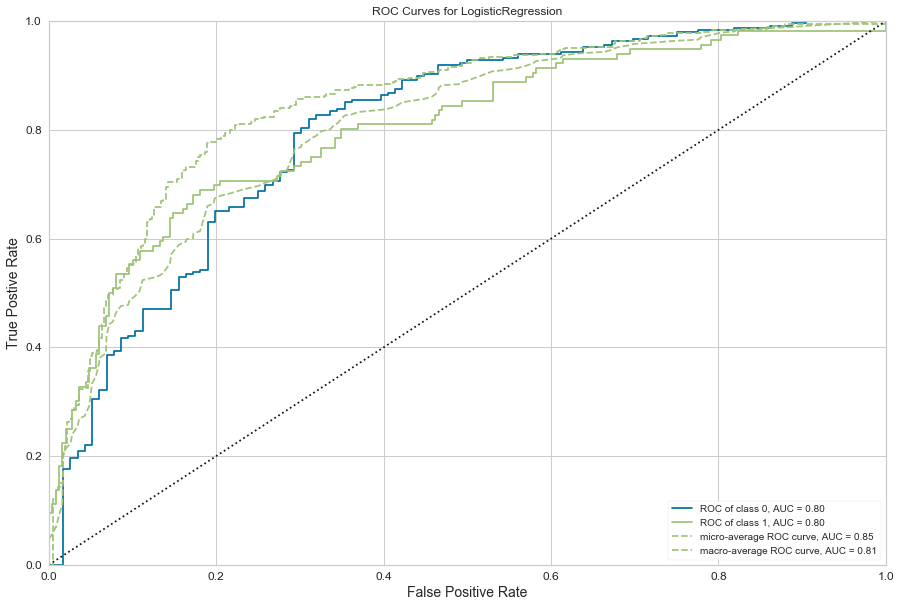

In [31]:
#Logistic Regression Train Set AUC
rocauc_logreg = ROCAUC(LogReg_3yr,size=(1080,720))
rocauc_logreg.score(X_train, y_train)
r_logreg = rocauc_logreg.poof()

In [32]:
#fit a gradient boosting classifier with low max_depth and early_stopping_rounds tuning to prevent overfitting
#form train test split from the existing training set for eval_set parameter
X_train_XGB, X_test_XGB, y_train_XGB, y_test_XGB = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


XGBReg_3yr = xgboost.XGBClassifier(max_depth=3,objective = 'binary:logistic')
XGBReg_3yr.fit(X_train_XGB,y_train_XGB,eval_set=[(X_test_XGB,y_test_XGB)],eval_metric= 'auc', early_stopping_rounds=20)
XGBReg_3y_train_pred = XGBReg_3yr.predict(X_train)

[0]	validation_0-auc:0.69000
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.72609
[2]	validation_0-auc:0.73870
[3]	validation_0-auc:0.73348
[4]	validation_0-auc:0.70696
[5]	validation_0-auc:0.72826
[6]	validation_0-auc:0.71522
[7]	validation_0-auc:0.73000
[8]	validation_0-auc:0.73043
[9]	validation_0-auc:0.73565
[10]	validation_0-auc:0.74870
[11]	validation_0-auc:0.74957
[12]	validation_0-auc:0.75087
[13]	validation_0-auc:0.74522
[14]	validation_0-auc:0.75043
[15]	validation_0-auc:0.74261
[16]	validation_0-auc:0.74000
[17]	validation_0-auc:0.74435
[18]	validation_0-auc:0.73957
[19]	validation_0-auc:0.74565
[20]	validation_0-auc:0.74130
[21]	validation_0-auc:0.74130
[22]	validation_0-auc:0.74391
[23]	validation_0-auc:0.74043
[24]	validation_0-auc:0.74304
[25]	validation_0-auc:0.74565
[26]	validation_0-auc:0.74957
[27]	validation_0-auc:0.75217
[28]	validation_0-auc:0.75304
[29]	validation_0-auc:0.75609
[30]	validation_0-auc:0.75522
[31]	validation_

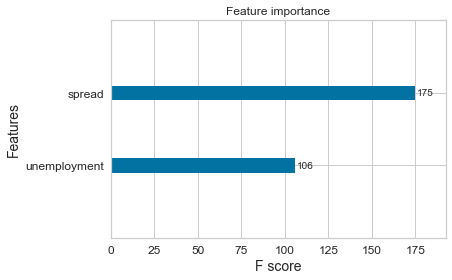

In [33]:
#xgboost feature importance

xgboost.plot_importance(XGBReg_3yr)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()


In [34]:
confusion_matrix(y_train,XGBReg_3y_train_pred)

array([[244,   5],
       [ 38,  78]], dtype=int64)

In [35]:
XGBReg_3yr.score(X_train, y_train)

0.8821917808219178

C:\Users\rguse\Anaconda3\envs\conda_env\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
C:\Users\rguse\Anaconda3\envs\conda_env\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


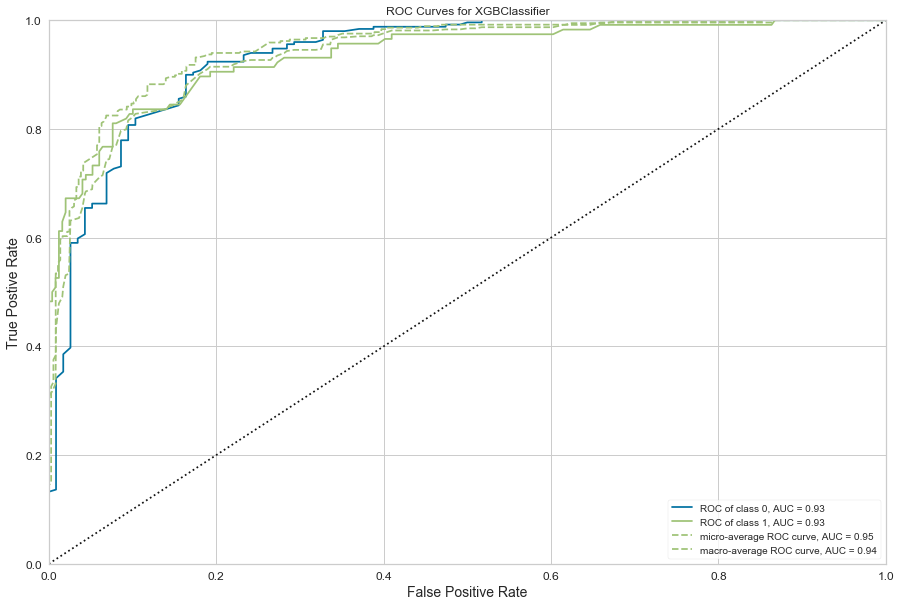

In [36]:
#XGBoost Train Set AUC
rocauc = ROCAUC(XGBReg_3yr,size=(1080,720))
rocauc.score(X_train, y_train)
r = rocauc.poof()

C:\Users\rguse\Anaconda3\envs\conda_env\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
C:\Users\rguse\Anaconda3\envs\conda_env\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


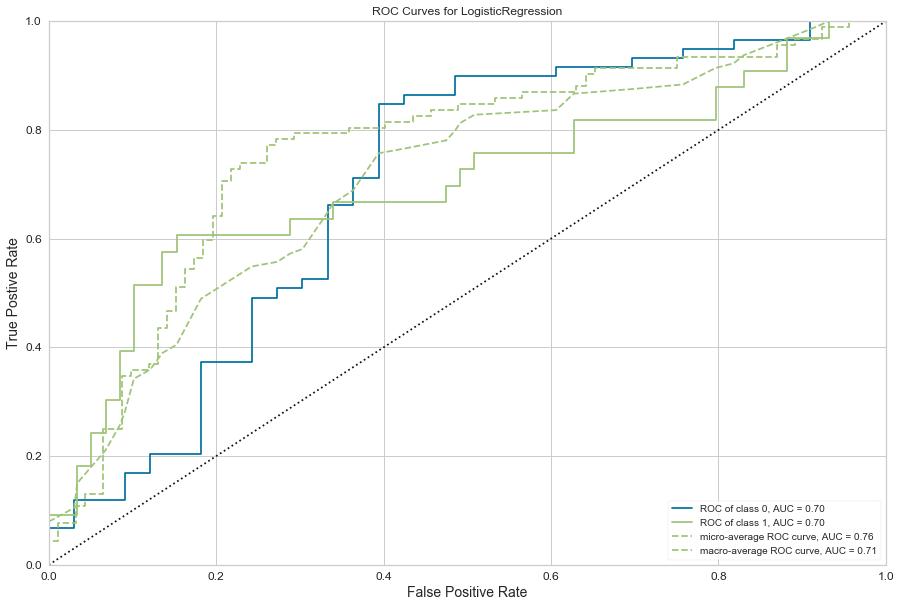

In [37]:
#Logistic Regression Test Set AUC
rocauc_LogReg_test = ROCAUC(LogReg_3yr,size=(1080,720))
rocauc_LogReg_test.score(X_test, y_test)
r = rocauc_LogReg_test.poof()

C:\Users\rguse\Anaconda3\envs\conda_env\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
C:\Users\rguse\Anaconda3\envs\conda_env\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


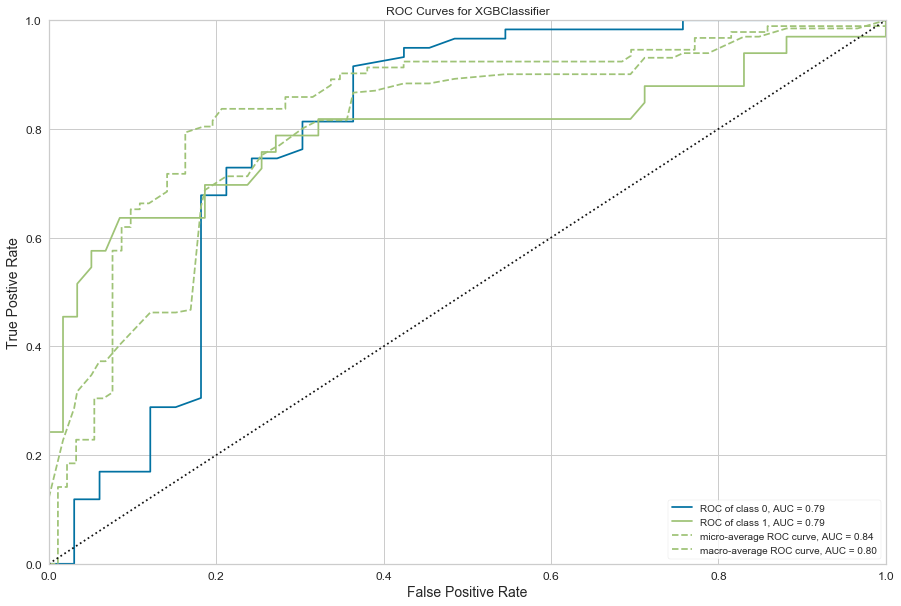

In [38]:
#XGBoost Test Set AUC
rocauc_XGB_test = ROCAUC(XGBReg_3yr,size=(1080,720))
rocauc_XGB_test.score(X_test, y_test)
r = rocauc_XGB_test.poof()